In [1]:
import pandas as pd
import warnings
import xarray as xr
import ephem
from datetime import datetime, timedelta
import math
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

from myconfig import *
output_path = output_path_buoy_data


In [2]:
station = '41043'
fname = 'https://www.ndbc.noaa.gov/data/realtime2/'+station+'.txt'
#more info: https://www.ndbc.noaa.gov/station_page.php?station=41043. 10 min intervals

In [3]:
df_buoy = pd.read_csv(fname, delim_whitespace=True, header=0, parse_dates=True,na_values='MM')
#delete units row
df_buoy = df_buoy.drop(index=0)
df_buoy.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
1,2024,10,20,21,20,110,5.0,7.0,2.3,13,8.3,354,1011.4,29.4,NaN,25.2,NaN,NaN,NaN
2,2024,10,20,21,10,110,5.0,7.0,2.3,NaN,8.3,354,1011.3,29.4,30.2,25.2,NaN,NaN,NaN
3,2024,10,20,21,00,110,5.0,7.0,NaN,NaN,NaN,NaN,1011.1,29.5,30.2,24.9,NaN,-0.8,NaN
4,2024,10,20,20,50,120,5.0,6.0,2.4,13,8.2,347,1011.2,29.4,NaN,25.1,NaN,NaN,NaN
5,2024,10,20,20,40,110,5.0,7.0,2.4,NaN,8.2,347,1011.3,29.6,30.2,24.5,NaN,NaN,NaN


In [4]:
# Rename columns to match expected input for to_datetime
df_buoy.rename(columns={"#YY": "year", "MM": "month", "DD": "day", "hh": "hour", "mm": "minute"}, inplace=True)

# Combine the date and time columns into a single timestamp
df_buoy['Timestamp'] = pd.to_datetime(df_buoy[['year', 'month', 'day', 'hour', 'minute']])

df_clean_buoy = df_buoy.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'DPD', 'MWD', 'PRES', 'DEWP', 'VIS', 'PTDY', 'TIDE']).drop(index=1)
#df_clean_buoy.dtypes


In [5]:
# Get the current date and calculate the threshold for the last 7 days
seven_days_ago = datetime.now() - timedelta(days=7)

# Filter the DataFrame to only keep rows from the last 7 days
df_last_7_days = df_clean_buoy[df_clean_buoy['Timestamp'] >= seven_days_ago]

df_last_7_days

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp
2,110,5.0,7.0,2.3,8.3,29.4,30.2,2024-10-20 21:10:00
3,110,5.0,7.0,NaN,NaN,29.5,30.2,2024-10-20 21:00:00
4,120,5.0,6.0,2.4,8.2,29.4,NaN,2024-10-20 20:50:00
5,110,5.0,7.0,2.4,8.2,29.6,30.2,2024-10-20 20:40:00
6,120,5.0,7.0,NaN,NaN,29.6,30.2,2024-10-20 20:30:00
...,...,...,...,...,...,...,...,...
1038,190,2.0,4.0,NaN,NaN,29.6,30.6,2024-10-13 15:30:00
1039,190,2.0,3.0,2.3,8.7,29.6,30.5,2024-10-13 15:20:00
1040,190,2.0,3.0,2.3,8.7,29.6,30.5,2024-10-13 15:10:00
1041,170,2.0,4.0,NaN,NaN,29.7,30.5,2024-10-13 15:00:00


In [6]:
#reverse the data
df_reversed_clean_buoy = df_last_7_days.iloc[::-1].reset_index(drop=True)
#df_last_1800 = df_reversed_clean_buoy.tail(1800).copy()

columns_to_convert = ['WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'ATMP', 'WTMP']

# Convert specified columns to float, using 'coerce' to handle errors
df_reversed_clean_buoy[columns_to_convert] = df_reversed_clean_buoy[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_reversed_clean_buoy = df_reversed_clean_buoy.reset_index(drop=True)
df_reversed_clean_buoy = df_reversed_clean_buoy.interpolate(method='linear', limit_direction='both')
df_reversed_clean_buoy.head()

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp
0,180.0,2.0,4.0,2.100000,8.80,29.6,30.5,2024-10-13 14:50:00
1,170.0,2.0,4.0,2.200000,8.75,29.7,30.5,2024-10-13 15:00:00
2,190.0,2.0,3.0,2.300000,8.70,29.6,30.5,2024-10-13 15:10:00
3,190.0,2.0,3.0,2.300000,8.70,29.6,30.5,2024-10-13 15:20:00
4,190.0,2.0,4.0,2.333333,8.80,29.6,30.6,2024-10-13 15:30:00


In [7]:
df_reversed_clean_buoy.shape

(1041, 8)

In [8]:
# Function to calculate sunlight for each timestamp
def calculate_sunlight(lat, lon, timestamps):
    # Initialize observer
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)

    # Initialize the Sun object
    sun = ephem.Sun()

    # Store results
    sunlight_data = []

    for timestamp in timestamps:
        observer.date = timestamp

        # Compute the position of the sun for the observer at the given time
        sun.compute(observer)

        # Altitude is in degrees (-90 to 90), where 90 is zenith and 0 is on the horizon
        altitude = sun.alt

        # Normalize sunlight (1 for zenith, 0 for horizon, and negative for below horizon)
        normalized_sunlight = max(0, altitude / ephem.degree)

        sunlight_data.append(normalized_sunlight)

    return pd.DataFrame({'timestamp': timestamps, 'sunlight_fraction': sunlight_data})

# Latitude and longitude for the given location
lat, lon =  19.71361111111111, -67.31083333333333

timestamps = df_reversed_clean_buoy['Timestamp']

# Calculate sunlight fraction for the entire time range
sunlight_df = calculate_sunlight(lat, lon, timestamps)

In [9]:
df_reversed_clean_buoy["sun_exposure"] = sunlight_df["sunlight_fraction"]

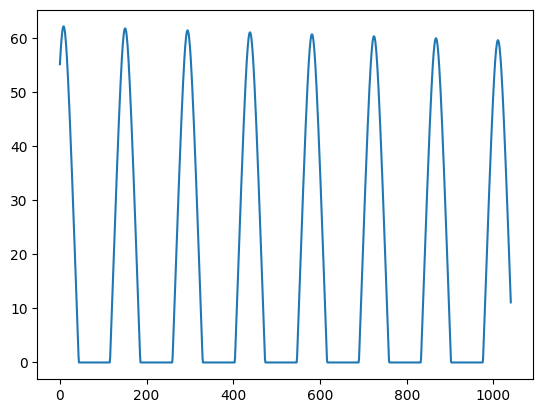

In [10]:
plt.plot(df_reversed_clean_buoy.sun_exposure)

In [11]:
new_index = np.linspace(0, len(df_reversed_clean_buoy) - 1, 7200)

df = df_reversed_clean_buoy
df_interpolated = pd.DataFrame()
for var in df.columns:
    if var=='Timestamp':
        continue
    df_interpolated[var] = np.interp(new_index, np.arange(len(df)), df[var])
# Interpolate 'timestamp' column onto the new index (if you want to interpolate timestamps too)
df_interpolated['Timestamp'] = pd.to_datetime(np.interp(new_index, np.arange(len(df)), df['Timestamp'].astype(int)))
df_interpolated['Timestamp'] = pd.to_datetime(df_interpolated['Timestamp'])
#print(df_interpolated.sun_exposure[0:20])

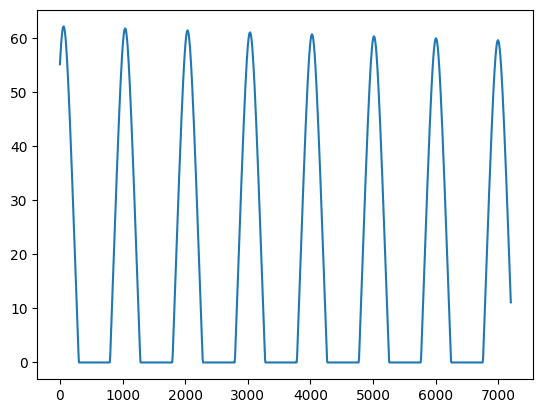

In [12]:
plt.plot(df_interpolated.sun_exposure)
#df_expanded.sun_exposure[60:120]

In [13]:
#normalize and park
# Assuming 'df' is already loaded and has the 'Sample' column
# Normalize the 'Sample' column using min-max normalization
df = df_interpolated
vars = ['WDIR','WSPD','GST','WVHT','APD','ATMP','WTMP']
df_normalized = df
for var in vars:
    df_normalized[var] = (df[var] - np.min(df[var])) / (np.max(df[var]) - np.min(df[var]))
# Display the resulting DataFrame (showing first and last 10 rows)

In [14]:
df_normalized.head(10)

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,sun_exposure,Timestamp
0,0.485608,0.144092,0.178265,0.521739,0.955689,0.782568,0.364723,55.152138,2024-10-13 14:50:00.000000000
1,0.480915,0.144092,0.178265,0.528020,0.954084,0.785201,0.364723,55.357682,2024-10-13 14:51:26.678705408
2,0.476223,0.144092,0.178265,0.534301,0.952479,0.787833,0.364723,55.563226,2024-10-13 14:52:53.357410816
3,0.471530,0.144092,0.178265,0.540582,0.950873,0.790466,0.364723,55.768769,2024-10-13 14:54:20.036116224
4,0.466837,0.144092,0.178265,0.546863,0.949268,0.793099,0.364723,55.974313,2024-10-13 14:55:46.714821376
5,0.462144,0.144092,0.178265,0.553144,0.947662,0.795731,0.364723,56.179856,2024-10-13 14:57:13.393526784
6,0.457452,0.144092,0.178265,0.559426,0.946057,0.798364,0.364723,56.385400,2024-10-13 14:58:40.072232192
7,0.453855,0.144092,0.177597,0.565707,0.944452,0.800586,0.364723,56.589530,2024-10-13 15:00:06.750937600
8,0.463241,0.144092,0.169012,0.571988,0.942846,0.797954,0.364723,56.776925,2024-10-13 15:01:33.429643008
9,0.472626,0.144092,0.160428,0.578269,0.941241,0.795321,0.364723,56.964320,2024-10-13 15:03:00.108348416


In [15]:
new_order = ['Timestamp','WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'ATMP', 'WTMP', 
       'sun_exposure']
new_df = df_normalized[new_order]
fname = output_path + 'buoy_nrt.csv'
new_df.to_csv(fname, index = False)

In [16]:
new_df.head(10)

,Timestamp,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,sun_exposure
0,2024-10-13 14:50:00.000000000,0.485608,0.144092,0.178265,0.521739,0.955689,0.782568,0.364723,55.152138
1,2024-10-13 14:51:26.678705408,0.480915,0.144092,0.178265,0.528020,0.954084,0.785201,0.364723,55.357682
2,2024-10-13 14:52:53.357410816,0.476223,0.144092,0.178265,0.534301,0.952479,0.787833,0.364723,55.563226
3,2024-10-13 14:54:20.036116224,0.471530,0.144092,0.178265,0.540582,0.950873,0.790466,0.364723,55.768769
4,2024-10-13 14:55:46.714821376,0.466837,0.144092,0.178265,0.546863,0.949268,0.793099,0.364723,55.974313
5,2024-10-13 14:57:13.393526784,0.462144,0.144092,0.178265,0.553144,0.947662,0.795731,0.364723,56.179856
6,2024-10-13 14:58:40.072232192,0.457452,0.144092,0.178265,0.559426,0.946057,0.798364,0.364723,56.385400
7,2024-10-13 15:00:06.750937600,0.453855,0.144092,0.177597,0.565707,0.944452,0.800586,0.364723,56.589530
8,2024-10-13 15:01:33.429643008,0.463241,0.144092,0.169012,0.571988,0.942846,0.797954,0.364723,56.776925
9,2024-10-13 15:03:00.108348416,0.472626,0.144092,0.160428,0.578269,0.941241,0.795321,0.364723,56.964320
